## Data Science Project: Analisis Data COVID19 di Dunia & ASEAN 

Covid19 adalah pandemi yang sudah mewabah ke seluruh dunia. Sebagian besar negara-negara di dunia sudah terjangkit. Penanganan tiap-tiap negara pun berbeda, sesuai dengan kebijakan pemerintah. Hal ini mengakibatkan perbedaan trend kenaikan atau penurunan kasus covid berbeda-beda tiap negara.

Pada kasus kali ini, kita akan mencoba menggali data covid19 dari salah satu open api yang tersedia yaitu https://covid19-api.org/.

In [9]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests

In [2]:
def get_json(api_url):
    response = requests.get(api_url)
    if response.status_code == 200:
        return json.loads(response.content.decode('utf-8'))
    else:
        return None

In [3]:
record_date = '2020-08-17'
covid_url = 'https://covid19-api.org/api/status?date='+ record_date
df_covid_worldwide = pd.io.json.json_normalize(get_json(covid_url))

print(df_covid_worldwide.head())

  country          last_update    cases  deaths  recovered
0      US  2020-08-16T23:27:50  5401167  170019    1833067
1      BR  2020-08-16T23:27:50  3340197  107852    2655017
2      IN  2020-08-16T23:27:50  2589682   49980    1862258
3      RU  2020-08-16T23:27:50   920719   15653     731444
4      ZA  2020-08-16T23:27:50   587345   11839     472377


In [4]:
df_covid_worldwide['last_update'] = pd.to_datetime(df_covid_worldwide['last_update'], format='%Y-%m-%d %H:%M:%S')
df_covid_worldwide['last_update'] = df_covid_worldwide['last_update'].apply(lambda x: x.date())

Mengambil data countries

In [5]:
countries_url = 'https://covid19-api.org/api/countries'
df_countries = pd.io.json.json_normalize(get_json(countries_url))
df_countries = df_countries.rename(columns={'alpha2': 'country'})[['name','country']]

print(df_countries.head())

          name country
0  Afghanistan      AF
1      Albania      AL
2      Algeria      DZ
3      Andorra      AD
4       Angola      AO


In [6]:
df_covid_denormalized = pd.merge(df_covid_worldwide, df_countries, on='country')

print(df_covid_denormalized.head())

  country last_update    cases  deaths  recovered                      name
0      US  2020-08-16  5401167  170019    1833067  United States of America
1      BR  2020-08-16  3340197  107852    2655017                    Brazil
2      IN  2020-08-16  2589682   49980    1862258                     India
3      RU  2020-08-16   920719   15653     731444        Russian Federation
4      ZA  2020-08-16   587345   11839     472377              South Africa


Menghitung Fatality Ratio

In [7]:
df_covid_denormalized['fatality_ratio'] = df_covid_denormalized['deaths']/df_covid_denormalized['cases']

Negara-negara dengan Fatality Ratio Tertinggi

In [8]:
df_top_20_fatality_rate = df_covid_denormalized.sort_values(by='fatality_ratio', ascending=False).head(20)

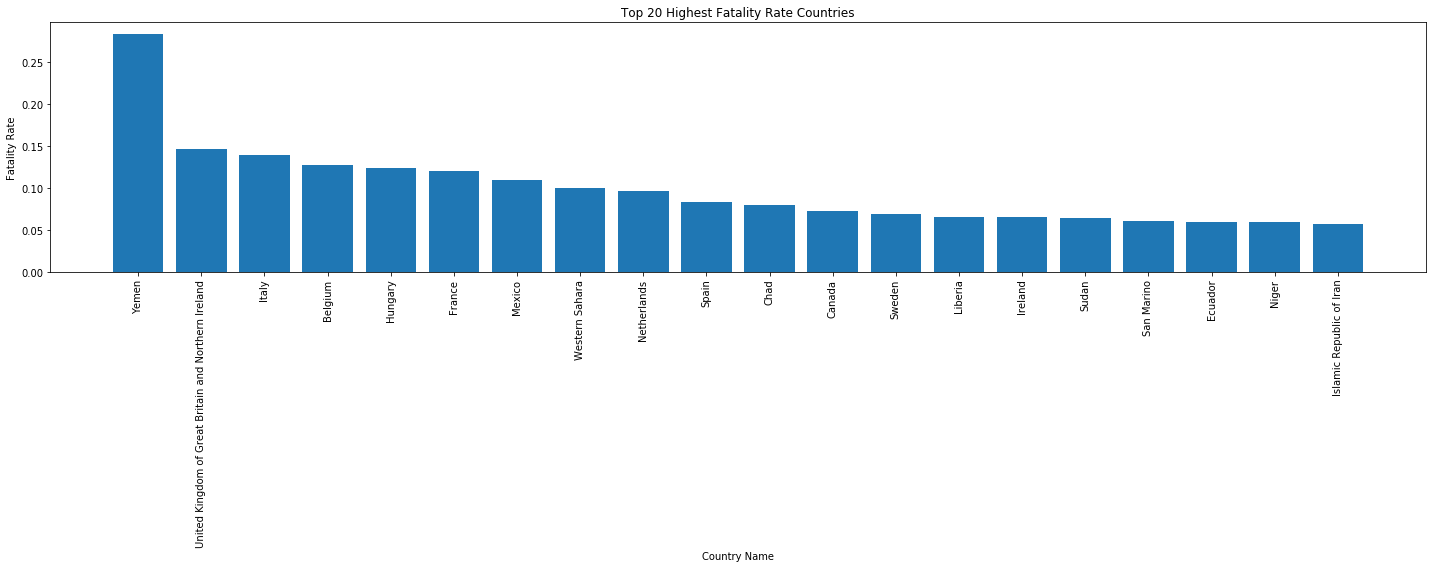

In [10]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 8))
x = df_top_20_fatality_rate['name']
y = df_top_20_fatality_rate['fatality_ratio']
plt.bar(x,y)
plt.xlabel('Country Name')
plt.ylabel('Fatality Rate')
plt.title('Top 20 Highest Fatality Rate Countries')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

Berdasarkan data diatas, Yaman merupakan negara dengan fatality ratio terbesar dengan jumlah hampir 2 kali lipat dari peringkat ke 2 Irlandia.

Menggabungkan Dataframe

Selanjutnya adalah membandingkan kasus covid19 di Indonesia (ID) dengan negara-negara tetangga, yaitu:

    MY -> Malaysia,
    SG -> Singapure,
    TH -> Thailand,
    VN -> Vietnam.

Untuk itu, api country dipanggil berkali-kali sebanyak negara yang akan kita bandingkan.

In [12]:
countries = ['ID','MY','SG','TH','VN']
i = 0
for country in countries:
    covid_timeline_url = 'https://covid19-api.org/api/timeline/'+ country
    df_covid_timeline = pd.io.json.json_normalize(get_json(covid_timeline_url))
    df_covid_timeline['last_update'] = pd.to_datetime(df_covid_timeline['last_update'], format='%Y-%m-%d %H:%M:%S')
    df_covid_timeline['last_update'] = df_covid_timeline['last_update'].apply(lambda x: x.date())
    if i==0:
        df_covid_timeline_merged = df_covid_timeline
    else:
        df_covid_timeline_merged = df_covid_timeline.append(df_covid_timeline_merged, ignore_index=True)
    i=i+1
    
print(df_covid_timeline_merged.head())

  country last_update  cases  deaths  recovered
0      VN  2020-09-20   1068      35        942
1      VN  2020-09-19   1068      35        942
2      VN  2020-09-18   1068      35        941
3      VN  2020-09-17   1066      35        940
4      VN  2020-09-16   1063      35        936


In [13]:
df_covid_timeline_denormalized = pd.merge(df_covid_timeline_merged, df_countries, on='country')


Kasus Covid-19 di ASEAN pada Bulan Maret 2020

In [14]:
import datetime
df_covid_timeline_denormalized = df_covid_timeline_denormalized[(df_covid_timeline_denormalized['last_update'] >= datetime.date(2020, 3, 1))]

C:\Users\user\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


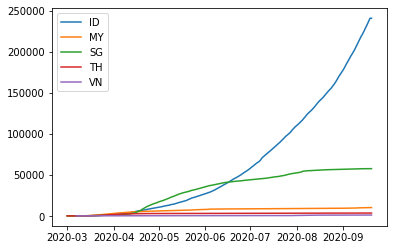

In [15]:
plt.clf()
countries = ['ID','MY','SG','TH','VN']
for country in countries:
    country_data = df_covid_timeline_denormalized['country']==country
    x =  df_covid_timeline_denormalized[country_data]['last_update']
    y = df_covid_timeline_denormalized[country_data]['cases']
    plt.plot(x, y, label = country)

plt.legend()

Berdasarkan grafik diatas, Indonesia memiliki kasus terbanyak se-Asean diikuti dengan Singapura, Malaysia, Thailand, dan Vietnam.